<h1>Moosinator 10,000</h1>
<h3>Turning cat audio into melspectrographic images for training</h3>


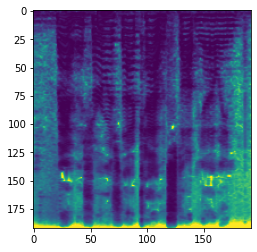

In [24]:
import numpy as np
import librosa as lr
import matplotlib.pyplot as plt
from pathlib import Path
import warnings
from PIL import Image
import os

def audio_to_image(path, height=192, width=192):
    signal, sr = lr.load(path, res_type='kaiser_fast')
    hl = signal.shape[0]//(width*1.1)
    spec = lr.feature.melspectrogram(signal, n_mels=height, hop_length=int(hl))
    img = lr.power_to_db(spec)**2
    start = (img.shape[1] - width) // 2
    return img[:, start:start+width]

meow_images = []
def cat_audio_to_images():
    for i in range(1,200):
        filename = 'data/cat_'+str(i)+'.wav'
        if Path('./'+filename).exists():
            with warnings.catch_warnings():
                warnings.simplefilter('ignore')
                img = audio_to_image(filename)
                meow_images.append(img)
                
                # Uncomment this code to save new data
                plt.imshow(img)
                plt.savefig('./images/training/cat/cat_'+str(i)+'.png')

def non_cat_audio_to_images():
    for i in range(1,22):
        filename = 'data_other/other_'+str(i)+'.wav'
        if Path('./'+filename).exists():
            with warnings.catch_warnings():
                warnings.simplefilter('ignore')
                img = audio_to_image(filename)
                meow_images.append(img)
                
                # Uncomment this code to save new data
                plt.imshow(img)
                plt.savefig('./images/training/other/other_'+str(i)+'.png')

# Uncomment this code to save new cat and non-cat data
#cat_audio_to_images()
#non_cat_audio_to_images()

<h3>Building the CNN</h3>

In [3]:
# Importing the Keras libraries and packages
from keras.models import Sequential
from keras.layers import Convolution2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense

# image size: 432x288
height = 432
width = 288

#Initialising the CNN
model = Sequential()
# Step 1 - Convolution
model.add(Convolution2D(32, 3, 3, input_shape = (height,width, 3), activation = 'relu'))
# Step 2 - Pooling
model.add(MaxPooling2D(pool_size = (2, 2)))
# Adding a second convolutional layer
model.add(Convolution2D(32, 3, 3, activation = 'relu'))
model.add(MaxPooling2D(pool_size = (2, 2)))
# Step 3 - Flattening
model.add(Flatten())
# Step 4 - Full connection
model.add(Dense(128, activation = 'relu'))
model.add(Dense(1, activation = 'sigmoid'))
# Compiling the CNN
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

<h3>Filter training images to the CNN</h3>

In [4]:
from keras.preprocessing.image import ImageDataGenerator

# Data Augmentation
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)
test_datagen = ImageDataGenerator(rescale = 1./255)
training_set = train_datagen.flow_from_directory(r"./images/training/",
                                                 target_size = (height,width),
                                                 batch_size = 32, #32
                                                 class_mode = 'binary')
test_set = test_datagen.flow_from_directory(r"./images/test/",
                                            target_size = (height,width),
                                            batch_size = 32, #32
                                            class_mode = 'binary')

Found 162 images belonging to 2 classes.
Found 14 images belonging to 2 classes.


<h3>Let's start the training!</h3>

In [5]:
epochs = 10
from tensorflow import keras

callbacks = [
    keras.callbacks.ModelCheckpoint("./models/meow_model.h5"),
]
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)
model.fit(
    training_set, epochs=epochs, callbacks=callbacks, validation_data=test_set,
)

Epoch 1/10
6/6 [==============================] - 8s 453ms/step - loss: 0.4186 - accuracy: 0.9012 - val_loss: 0.8777 - val_accuracy: 0.6429
Epoch 2/10
6/6 [==============================] - 3s 482ms/step - loss: 0.3416 - accuracy: 0.9012 - val_loss: 1.0803 - val_accuracy: 0.6429
Epoch 3/10
6/6 [==============================] - 3s 521ms/step - loss: 0.3956 - accuracy: 0.9012 - val_loss: 1.2430 - val_accuracy: 0.6429
Epoch 4/10
6/6 [==============================] - 3s 350ms/step - loss: 0.3480 - accuracy: 0.9012 - val_loss: 0.7785 - val_accuracy: 0.6429
Epoch 5/10
6/6 [==============================] - 3s 429ms/step - loss: 0.3230 - accuracy: 0.9012 - val_loss: 0.9133 - val_accuracy: 0.6429
Epoch 6/10
6/6 [==============================] - 3s 426ms/step - loss: 0.3254 - accuracy: 0.9012 - val_loss: 1.2171 - val_accuracy: 0.6429
Epoch 7/10
6/6 [==============================] - 3s 422ms/step - loss: 0.3184 - accuracy: 0.9012 - val_loss: 0.8937 - val_accuracy: 0.6429
Epoch 8/10
6/6 [====

<h3>Loading the model</h3>

If you've already trained the model, you can skip the above cell and jump straight to this part.

In [28]:
model = keras.models.load_model('models/meow_model.h5')

<h3>Running the model on new data</h3>

In [7]:
import tensorflow as tf

def run_inference_on_new_data(audio_path, img_path):
    #img = audio_to_image(audio_path)
    #plt.imshow(img)
    #plt.savefig(img_path)

    # classify this image as a meow or not
    image_size = (432, 288)
    img = keras.preprocessing.image.load_img(img_path, target_size=image_size)
    img_array = keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)  # Create batch axis
    predictions = model.predict(img_array)
    score = predictions[0]
    return 100 * (1-score[0])

In [8]:
print ('probability of meow (sound is \'meow\'):', str(run_inference_on_new_data('./audio_to_analyze/meow.wav', 'images_to_analyze/meow.png')) + '%')

probability of meow (sound is 'meow'): 100.0%


In [9]:
print ('probability of meow (sound is \'achoo\'):', str(run_inference_on_new_data('./audio_to_analyze/achoo.wav', 'images_to_analyze/achoo.png')) + '%')

probability of meow (sound is 'achoo'): 100.0%
